# Cuaderno 2: Reducción de Dimensión, BNMF y Clustering

**Continuación directa del Cuaderno 1: utiliza los datos limpios y procesados exportados previamente.**

---

## Diagrama de Flujo del Cuaderno

```
1. Estandarización (StandardScaler)
   ↓
2. PCA (Análisis de Componentes Principales)
   ↓
3. BNMF (Bayesian Non-Negative Matrix Factorization)
   ↓
4. Clustering (k-Means / GMM)
   ↓
5. Visualización y Exportación
```

In [66]:
# Sanity check: print shapes of major artifacts used in BNMF/NMF
print("=== BNMF / NMF artifacts summary ===")
for name in ['V','W','H','WH','W_used','H_used','X_small','X_scaled']:
    if name in globals():
        obj = globals()[name]
        try:
            s = obj.shape
        except Exception:
            s = 'N/A'
        print(f"{name}: {s}")
    else:
        print(f"{name}: not defined")

=== BNMF / NMF artifacts summary ===
V: (100, 10)
W: (100, 5)
H: (5, 26)
WH: (100, 10)
W_used: (100, 3)
H_used: (3, 10)
X_small: (100, 10)
X_scaled: (100, 26)


## 1. Estandarización de los Datos
Se cargan los datos limpios del cuaderno 1 y se aplica StandardScaler.

In [67]:
# Cargar datos limpios del cuaderno 1
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('processed_data/data_prepared.csv')
X = df.drop(columns=['hospital_expire_flag', 'data_split'], errors='ignore')

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. PCA: Análisis de Componentes Principales
Se calcula la varianza explicada y se selecciona el número óptimo de componentes.

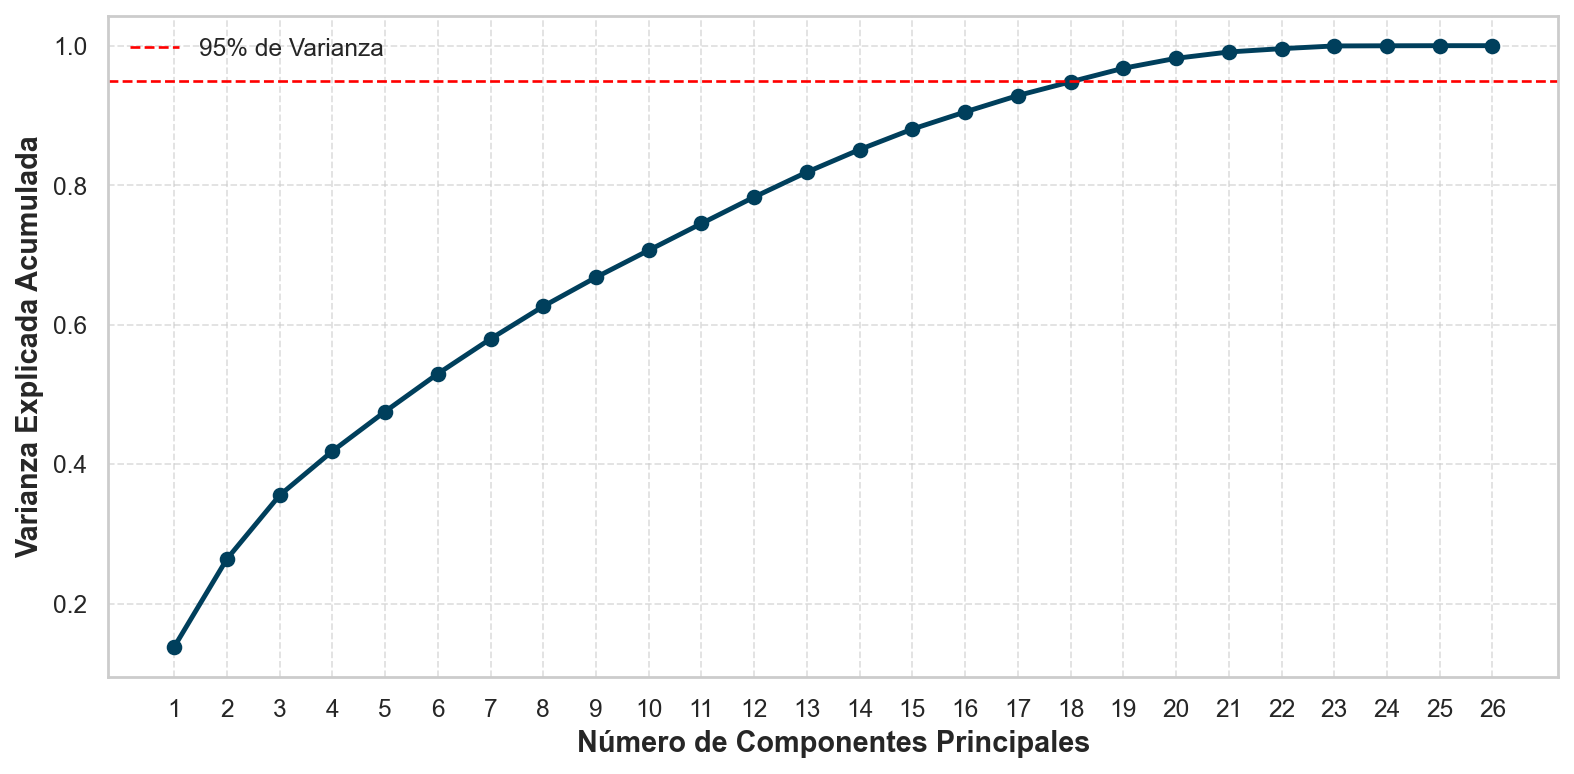

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

# --- Professional PCA Plot ---
plt.figure(figsize=(10, 5), dpi=160)

plt.plot(
    range(1, len(explained_var)+1),
    cum_var,
    marker='o',
    markersize=6,
    linewidth=2.2,
    color='#003f5c'  # academic dark blue
)

# Aesthetic improvements
plt.xticks(
    ticks=range(1, len(explained_var)+1),
    fontsize=11,
    rotation=0
)
plt.yticks(fontsize=11)

plt.xlabel('Número de Componentes Principales', fontsize=13, fontweight='bold')
plt.ylabel('Varianza Explicada Acumulada', fontsize=13, fontweight='bold')
plt.title('', fontsize=15, fontweight='bold', pad=15)

# Grid aesthetic
plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.6)

# Add threshold reference line (95%)
plt.axhline(0.95, color='red', linestyle='--', linewidth=1.2, label='95% de Varianza')

plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.savefig('figures/pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. BNMF: Bayesian Non-Negative Matrix Factorization
Se aplica BNMF, se obtienen matrices W y H, y se interpretan los componentes.

In [69]:
# BNMF (Bayesian NMF) using PyMC if available, otherwise fallback to scikit-learn NMF.
# If you want to use the Bayesian approach, install PyMC and ArviZ:
#   pip install pymc arviz

import numpy as np
from sklearn.decomposition import NMF

# Try to import PyMC (Bayesian approach); if not available, use sklearn NMF as fallback
PYMC_AVAILABLE = False
try:
    import pymc as pm
    import arviz as az
    PYMC_AVAILABLE = True
except Exception as _e:
    print("PyMC (or ArviZ) not available. Falling back to scikit-learn NMF.\nInstall with: pip install pymc arviz if you want BNMF.")

# Use a small matrix for demonstration (speed)
X_small = np.abs(X_scaled[:100, :10])
n, m = X_small.shape
k = 3  # number of components

if PYMC_AVAILABLE:
    # Bayesian NMF model (PyMC) - NOTE: slower and computationally costy
    with pm.Model() as bnmf_model:
        W = pm.HalfNormal('W', sigma=1, shape=(n, k))
        H = pm.HalfNormal('H', sigma=1, shape=(k, m))
        X_hat = pm.math.dot(W, H)
        sigma = pm.HalfNormal('sigma', sigma=1)
        X_obs = pm.Normal('X_obs', mu=X_hat, sigma=sigma, observed=X_small)
        trace = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=True)

    # Extract posterior means for W and H
    W_post = trace.posterior['W'].mean(dim=["chain", "draw"]).values
    H_post = trace.posterior['H'].mean(dim=["chain", "draw"]).values
    print('BNMF (PyMC) result:')
    print('Forma de W (BNMF):', W_post.shape)
    print('Forma de H (BNMF):', H_post.shape)
    W_used = W_post
    H_used = H_post
    # Alias names for backward compatibility with later cells
    W = W_used
    H = H_used
    V = X_small
    try:
        WH = W @ H
    except Exception:
        WH = None
else: 
    # Fallback: standard NMF from scikit-learn
    print('Using scikit-learn NMF (non-Bayesian fallback)')
    nmf = NMF(n_components=k, init='nndsvda', random_state=42, solver='mu', beta_loss='kullback-leibler', max_iter=500)
    W_nmf = nmf.fit_transform(np.abs(X_small))
    H_nmf = nmf.components_
    print('Forma de W (NMF):', W_nmf.shape)
    print('Forma de H (NMF):', H_nmf.shape)
    W_used = W_nmf
    H_used = H_nmf
    # To keep later plotting consistent, also alias W and H to W_used/H_used
    W = W_used
    H = H_used
    # Small original matrix used for factorization visualizations
    V = X_small
    try:
        WH = W @ H
    except Exception:
        WH = None

PyMC (or ArviZ) not available. Falling back to scikit-learn NMF.
Install with: pip install pymc arviz if you want BNMF.
Using scikit-learn NMF (non-Bayesian fallback)
Forma de W (NMF): (100, 3)
Forma de H (NMF): (3, 10)


### Nota sobre BNMF en Python
**¿Por qué no se usa una librería estándar de BNMF?**
Actualmente, no existe una implementación de BNMF (Bayesian Non-Negative Matrix Factorization) en librerías populares de Python como scikit-learn. BNMF es una extensión probabilística de NMF que utiliza inferencia bayesiana para estimar las matrices W y H, permitiendo incorporar incertidumbre y regularización automática.

**Opciones para implementar BNMF:**

- Usar librerías de modelado probabilístico como PyMC o Pyro para construir el modelo y realizar inferencia bayesiana (más avanzado y computacionalmente costoso).

- Utilizar NMF estándar como aproximación y documentar la diferencia.

A continuación se muestra un ejemplo de cómo se podría implementar BNMF con PyMC:

In [70]:
# Instala scikit-learn-extra si no lo tienes: pip install scikit-learn-extra
from sklearn.decomposition import NMF

n_components = 5  # Ajusta según tu análisis
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42, solver='mu', beta_loss='kullback-leibler', max_iter=500)
W = nmf.fit_transform(abs(X_scaled))
H = nmf.components_

print('Forma de W:', W.shape)
print('Forma de H:', H.shape)

Forma de W: (100, 5)
Forma de H: (5, 26)


### Interpretación de Componentes (W y H)
Explica qué representa cada componente y muestra los pesos principales.

In [71]:
import numpy as np
for i, comp in enumerate(H):
    print(f'Componente {i+1}:')
    top_features = np.argsort(comp)[-5:][::-1]
    print('  Principales variables:', X.columns[top_features].tolist())

Componente 1:
  Principales variables: ['subject_id', '51010', '50954', '51104', '50910']
Componente 2:
  Principales variables: ['50924', '51054', '51458', '51047', 'subject_id']
Componente 3:
  Principales variables: ['50963', '51438', '51457', '51439', 'subject_id']
Componente 4:
  Principales variables: ['50900', '51362', '50973', '51384', 'subject_id']
Componente 5:
  Principales variables: ['51218', '51108', '50950', '50915', '50924']


## 4. Clustering sobre Componentes
Se aplica k-Means y/o GMM sobre los componentes de BNMF y PCA, y se compara el desempeño.

In [72]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Clustering sobre BNMF
kmeans_bnmf = KMeans(n_clusters=3, random_state=42).fit(W)
labels_bnmf = kmeans_bnmf.labels_

# Clustering sobre PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42).fit(X_pca[:, :n_components])
labels_pca = kmeans_pca.labels_

## 5. Visualización de Clusters y Componentes
Gráficas en el espacio reducido y distribución de componentes.

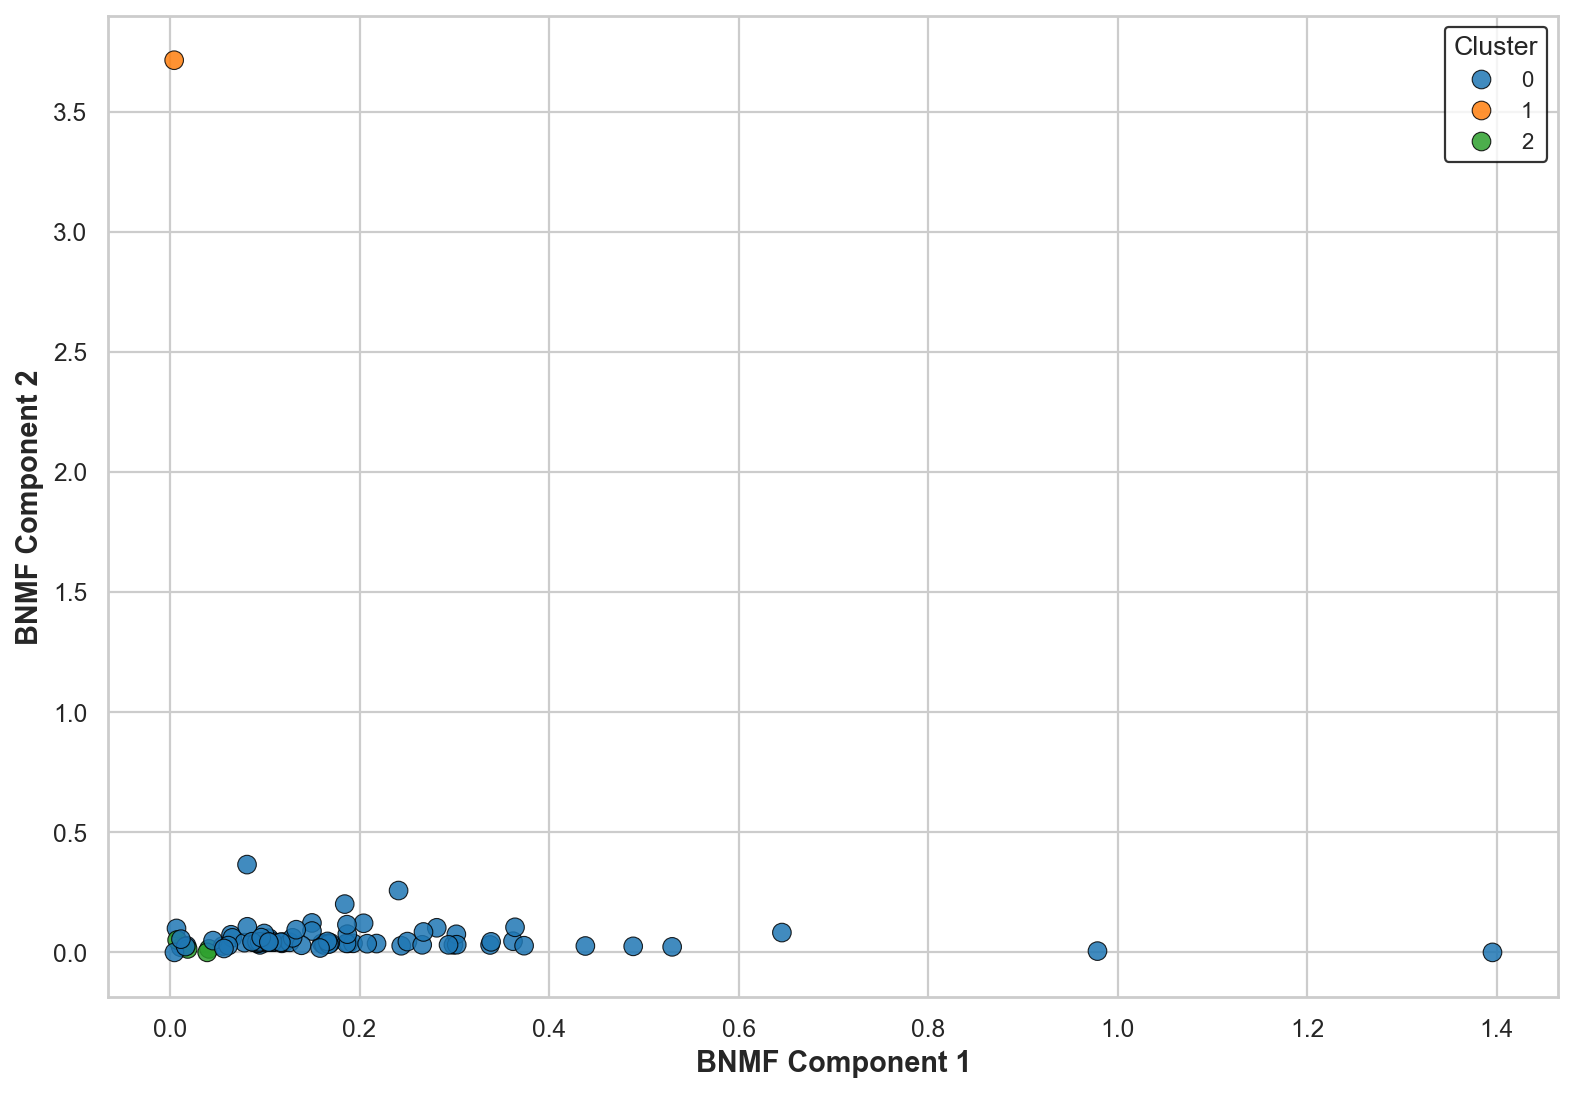

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo profesional
sns.set(style="whitegrid")

plt.figure(figsize=(10, 7), dpi=160)

sns.scatterplot(
    x=W[:, 0],
    y=W[:, 1],
    hue=labels_bnmf,
    palette='tab10',               # paleta científica
    s=70,                          # tamaño de puntos
    edgecolor='black',             # borde para resaltar
    linewidth=0.5,
    alpha=0.85                     # transparencia suave
)

plt.xlabel('BNMF Component 1', fontsize=13, fontweight='bold')
plt.ylabel('BNMF Component 2', fontsize=13, fontweight='bold')
plt.title('', fontsize=16, fontweight='bold')

plt.legend(title='Cluster', fontsize=10, frameon=True, edgecolor='black')
plt.tight_layout()

plt.savefig('figures/clusters_bnmf.png', dpi=300, bbox_inches='tight')
plt.show()


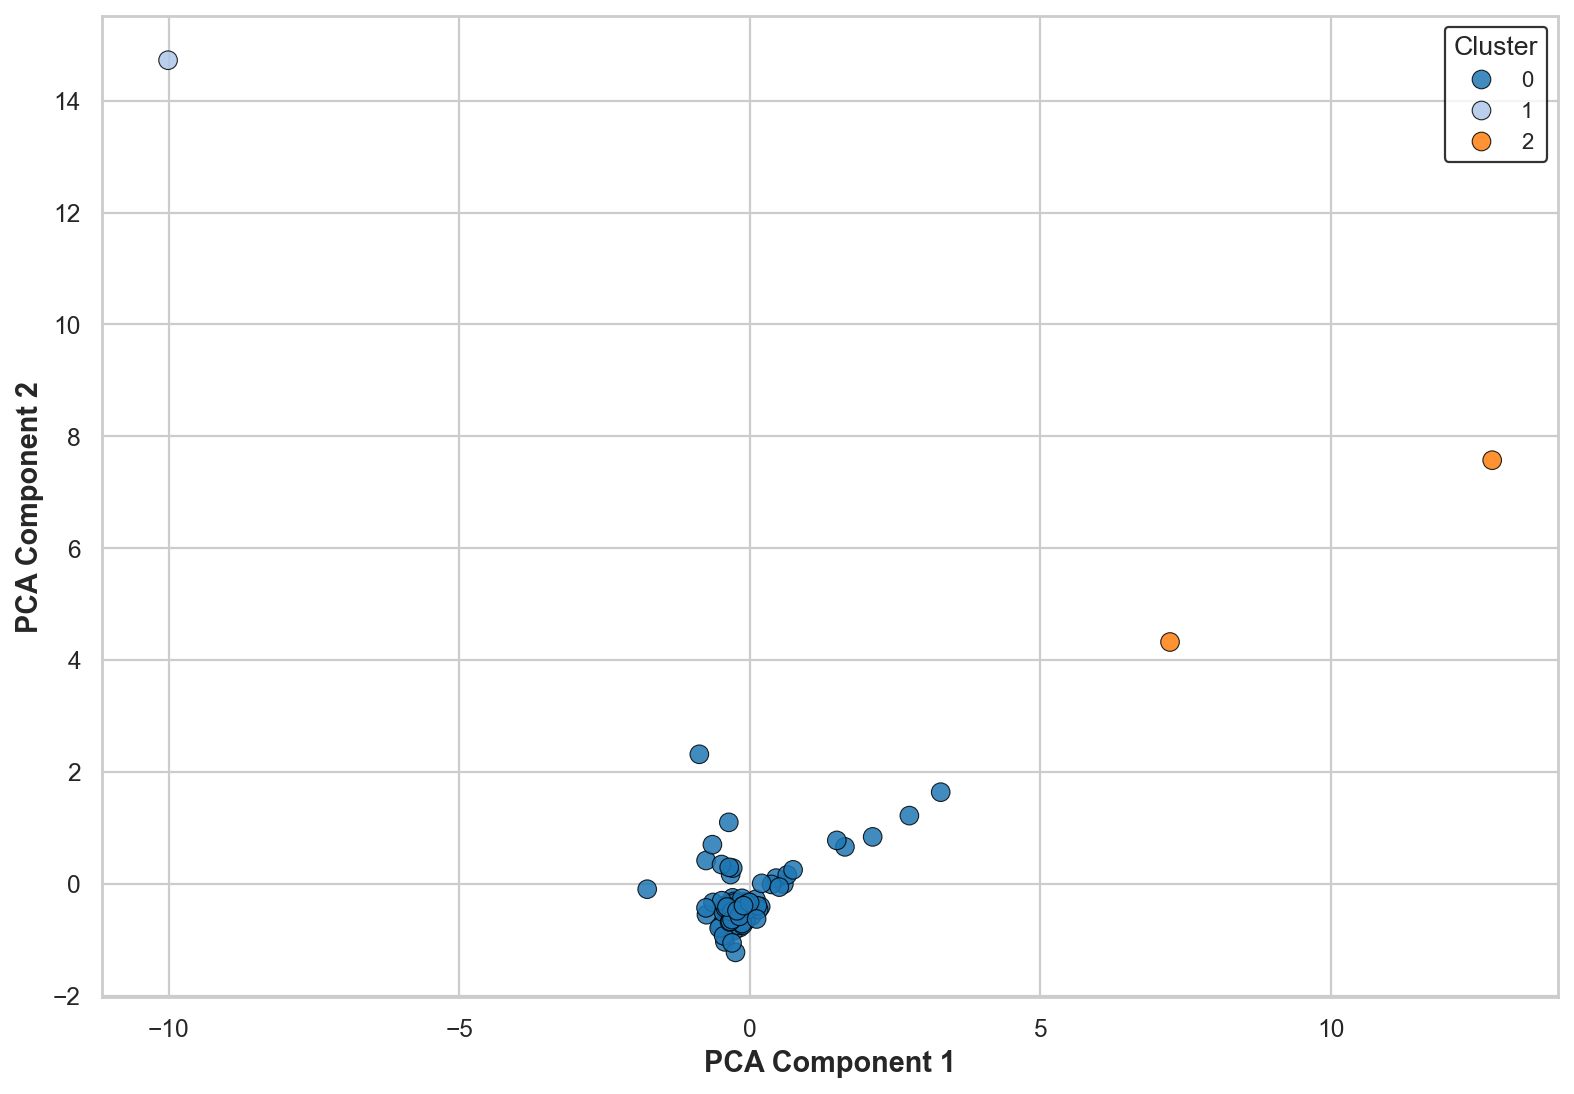

In [74]:
plt.figure(figsize=(10, 7), dpi=160)

sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_pca,
    palette='tab20',          # diferenciación mejorada para muchos clusters
    s=70,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85
)

plt.xlabel('PCA Component 1', fontsize=13, fontweight='bold')
plt.ylabel('PCA Component 2', fontsize=13, fontweight='bold')
plt.title('', fontsize=16, fontweight='bold')

plt.legend(title='Cluster', fontsize=10, frameon=True, edgecolor='black')
plt.tight_layout()

plt.savefig('figures/clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()


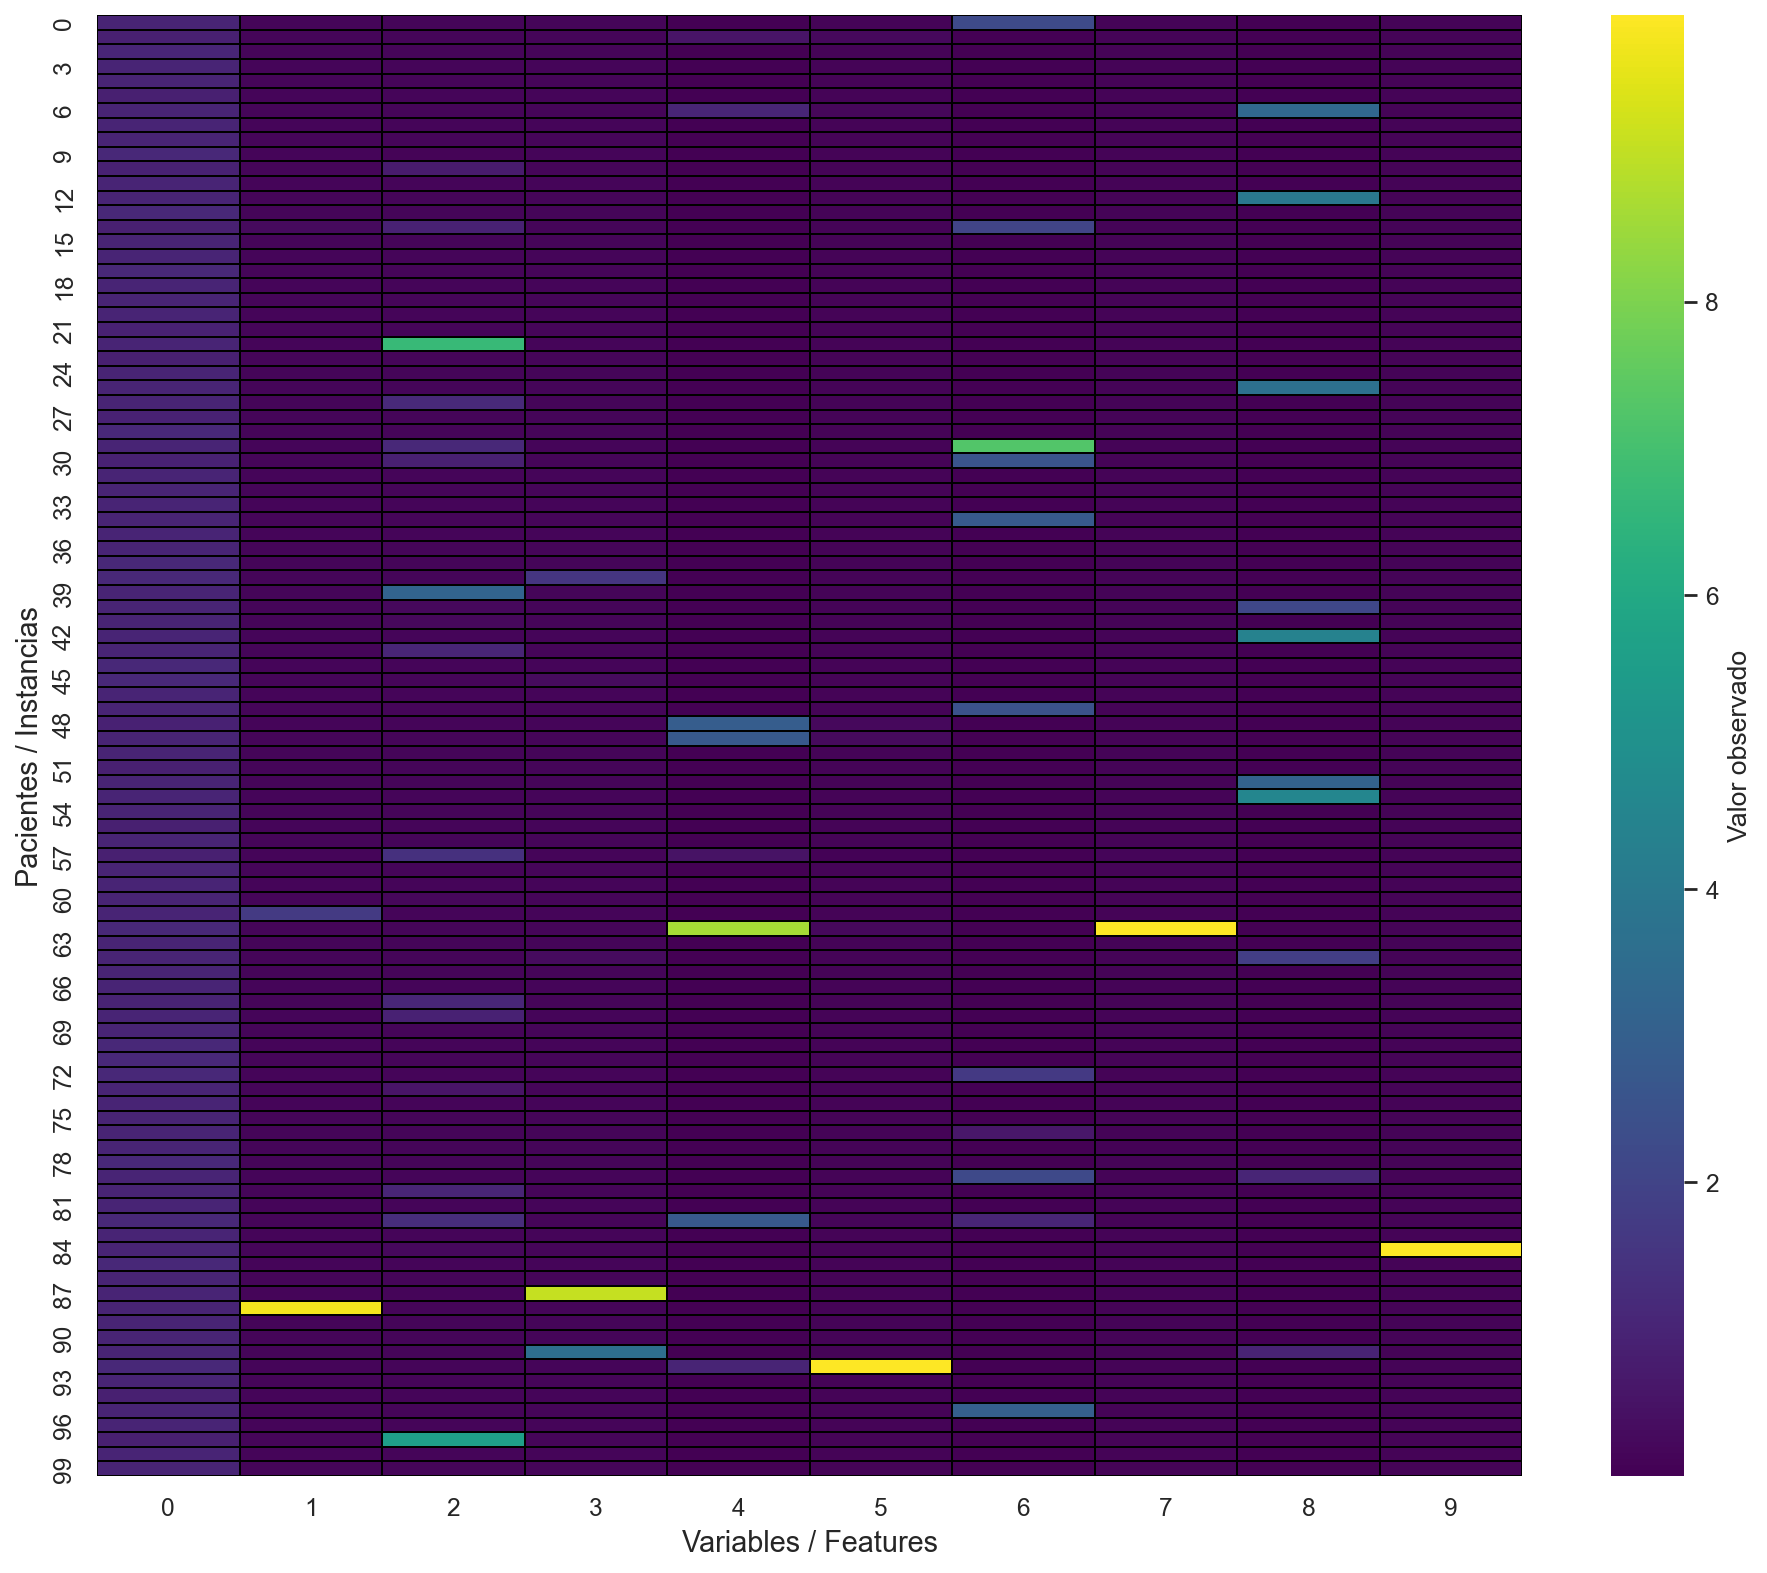

In [75]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 10), dpi=160)

# Resolve V fallback for plotting
if 'V' in globals():
    _V = V
elif 'X_small' in globals():
    _V = X_small
elif 'X_scaled' in globals():
    try:
        _V = np.abs(X_scaled[:100, :10])
    except Exception:
        _V = X_scaled
else:
    raise NameError("V is not defined. Run the BNMF/NMF cell or create X_small/X_scaled first.")

sns.heatmap(
    _V,
    cmap="viridis",          # paleta científica
    cbar_kws={'label': 'Valor observado'},
    linewidths=0.2,
    linecolor='black'
)

plt.title('', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Variables / Features', fontsize=13)
plt.ylabel('Pacientes / Instancias', fontsize=13)

plt.tight_layout()
plt.savefig('figures/heatmap_V_original.png', dpi=300, bbox_inches='tight')
plt.show()


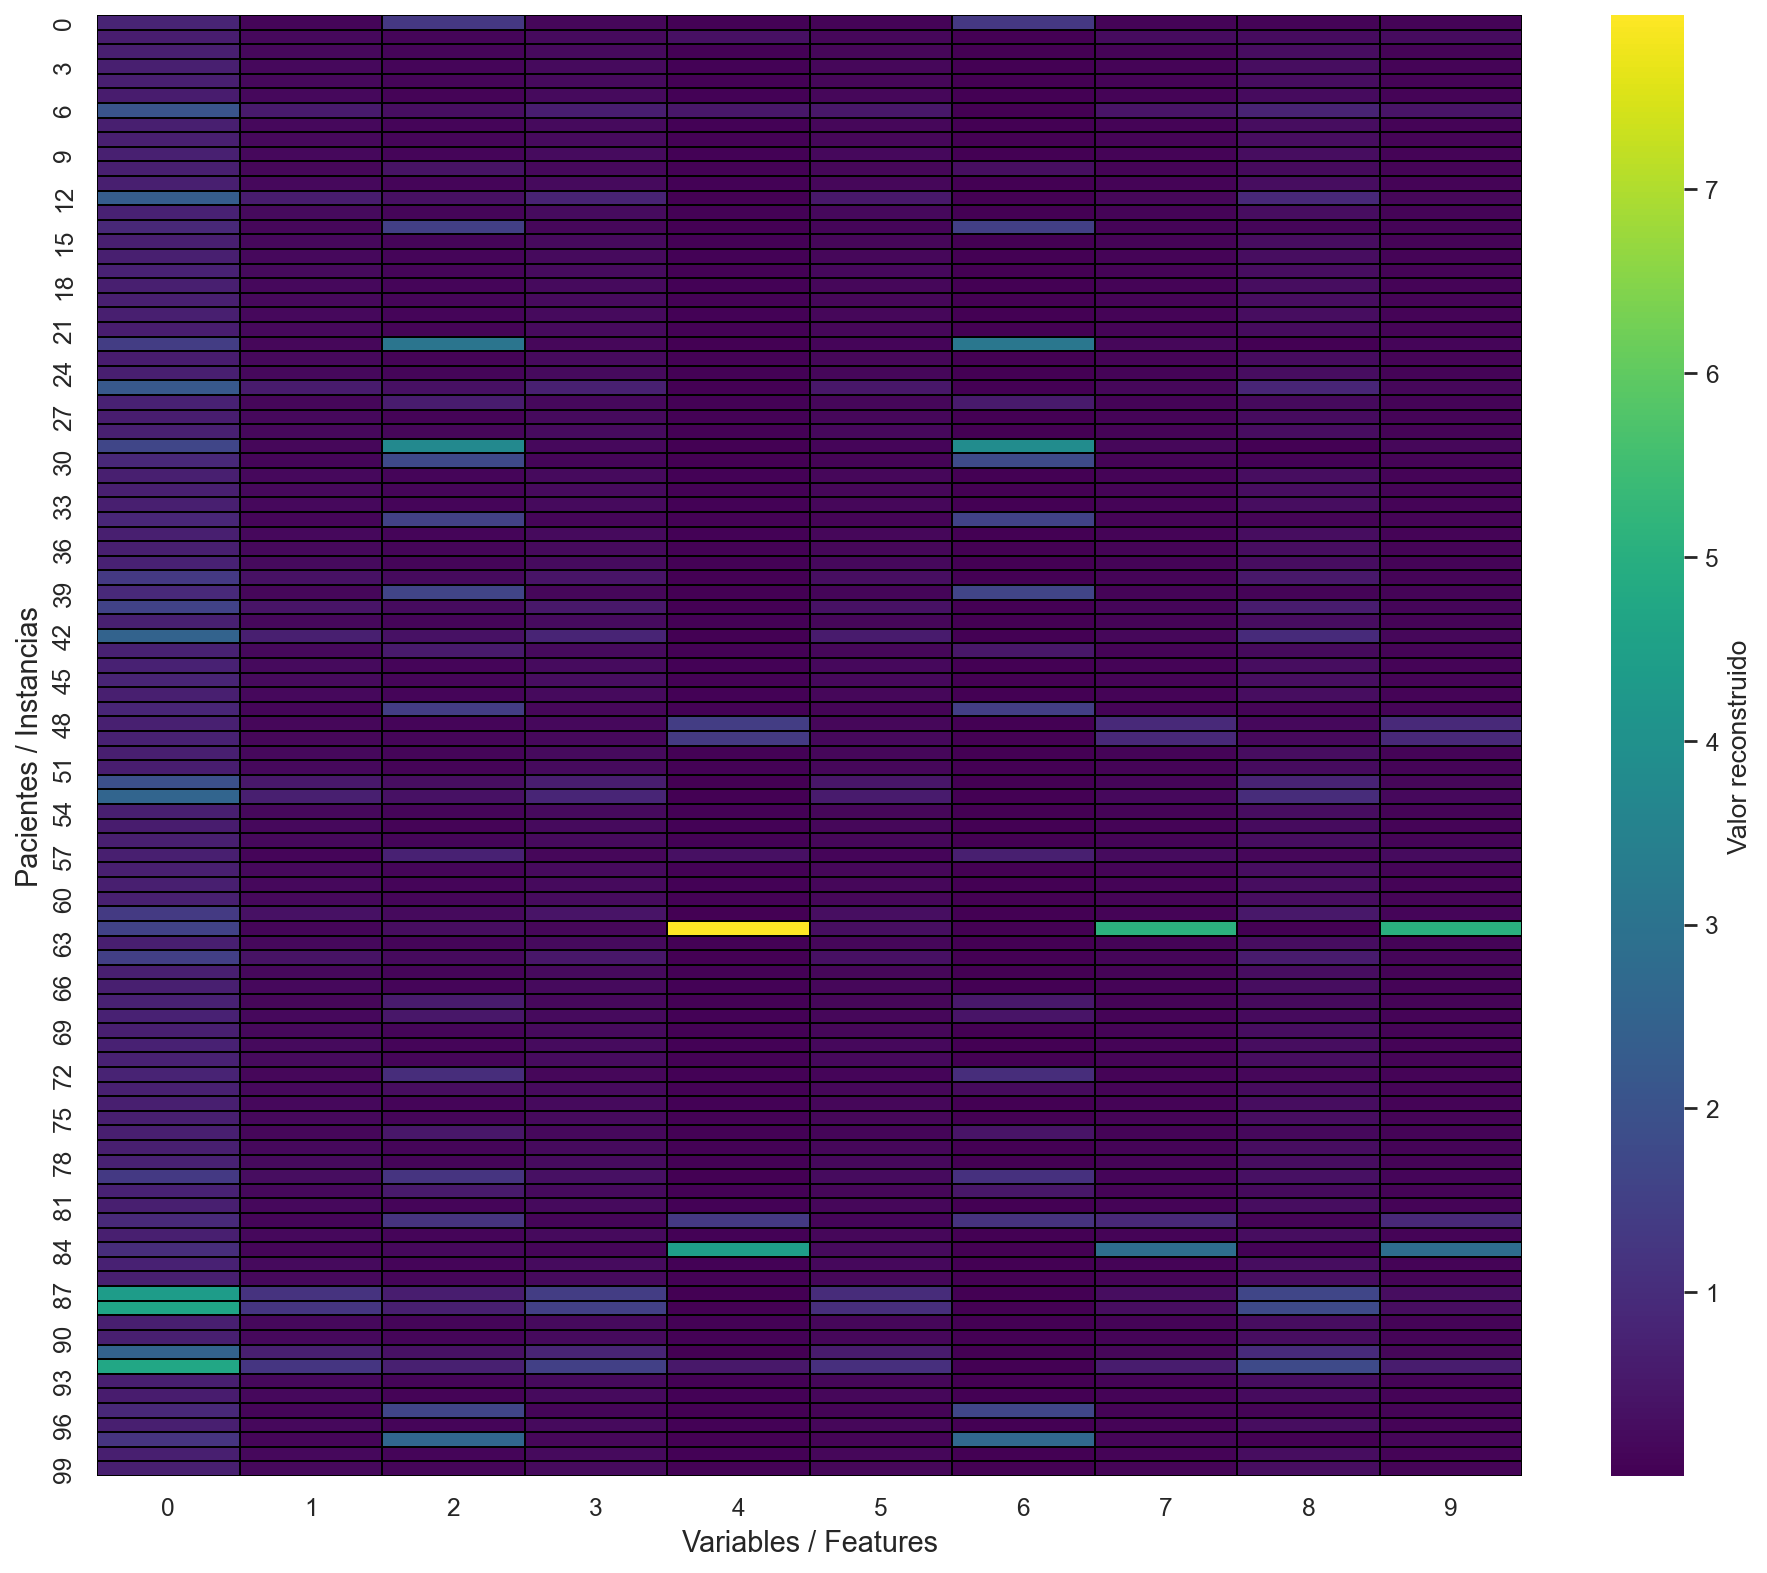

In [76]:
import numpy as np
plt.figure(figsize=(12, 10), dpi=160)

# Resolve WH fallback for plotting
if 'WH' in globals() and WH is not None:
    _WH = WH
elif 'W_used' in globals() and 'H_used' in globals():
    _WH = W_used @ H_used
elif 'W' in globals() and 'H' in globals():
    _WH = W @ H
else:
    raise NameError("WH is not defined. Run the BNMF/NMF cell to create W and H first.")

sns.heatmap(
    _WH,
    cmap="viridis",        # paleta científica para reconstrucción
    cbar_kws={'label': 'Valor reconstruido'},
    linewidths=0.2,
    linecolor='black'
)

plt.title('', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Variables / Features', fontsize=13)
plt.ylabel('Pacientes / Instancias', fontsize=13)

plt.tight_layout()
plt.savefig('figures/heatmap_WH_reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()


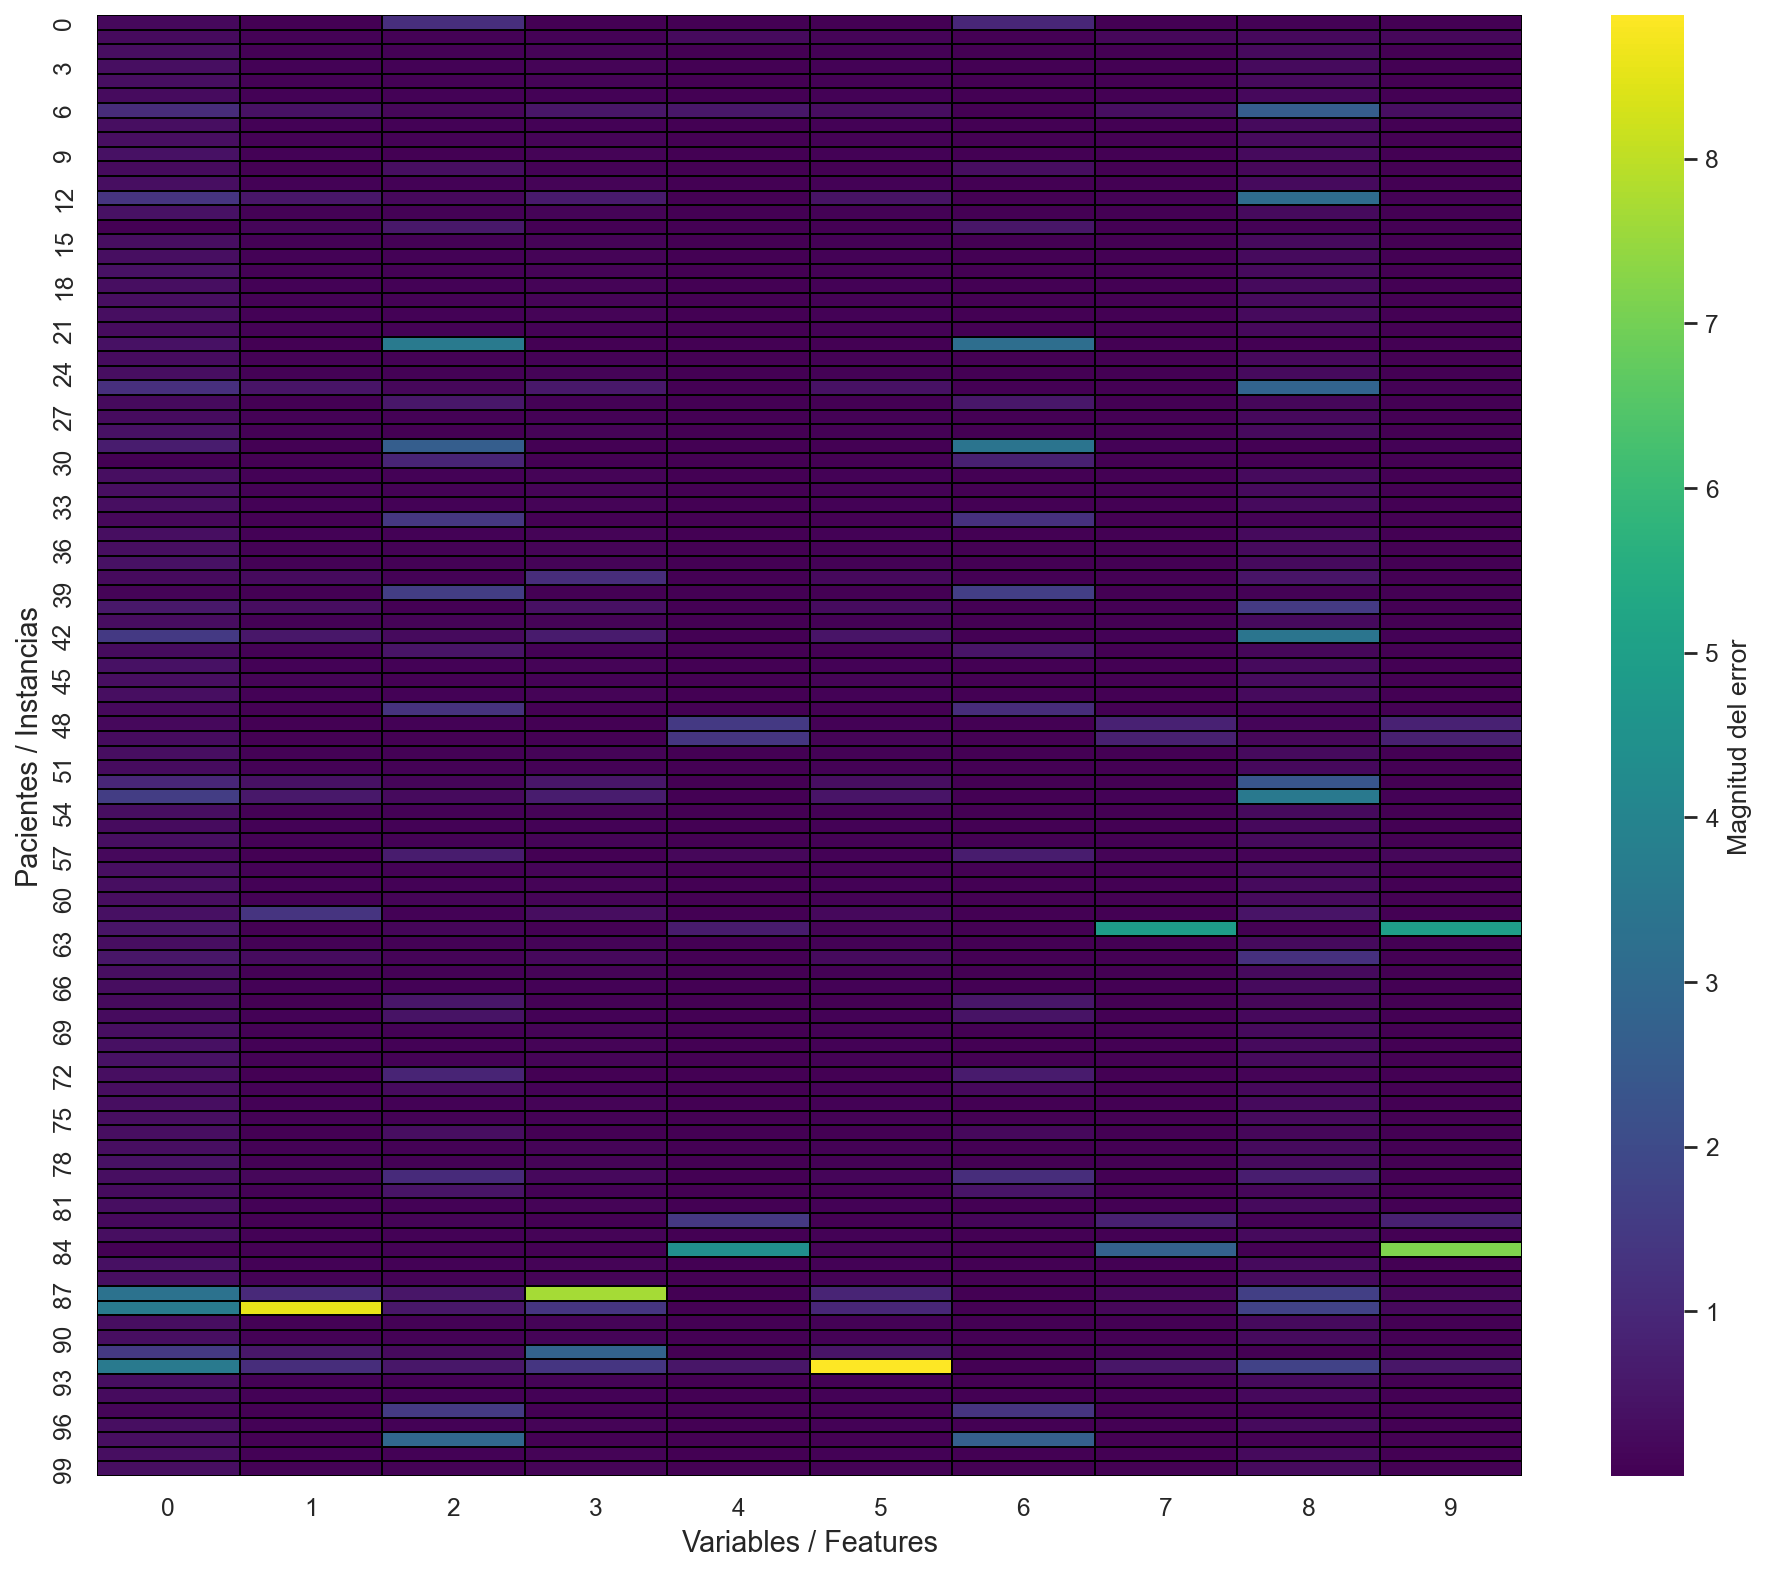

In [77]:
import numpy as np
plt.figure(figsize=(12, 10), dpi=160)

# Resolve V and WH fallback for plotting the absolute error
if 'V' in globals():
    _V = V
elif 'X_small' in globals():
    _V = X_small
elif 'X_scaled' in globals():
    try:
        _V = np.abs(X_scaled[:100, :10])
    except Exception:
        _V = X_scaled
else:
    raise NameError("V is not defined. Run the BNMF/NMF cell or create X_small/X_scaled first.")

if 'WH' in globals() and WH is not None:
    _WH = WH
elif 'W_used' in globals() and 'H_used' in globals():
    _WH = W_used @ H_used
elif 'W' in globals() and 'H' in globals():
    _WH = W @ H
else:
    _WH = None

if _WH is None:
    raise NameError("WH is not defined. Create WH by computing W @ H")

# Ensure shapes align for subtraction
if _V.shape != _WH.shape:
    raise ValueError(f"Shape mismatch between V ({_V.shape}) and WH ({_WH.shape}). Ensure consistent matrix sizes.")

sns.heatmap(
    np.abs(_V - _WH),
    cmap="viridis",        # paleta para representar error
    cbar_kws={'label': 'Magnitud del error'},
    linewidths=0.2,
    linecolor='black'
)

plt.title('', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Variables / Features', fontsize=13)
plt.ylabel('Pacientes / Instancias', fontsize=13)

plt.tight_layout()
plt.savefig('figures/heatmap_error.png', dpi=300, bbox_inches='tight')
plt.show()


UMAP not available or failed; falling back to t-SNE. Error: No module named 'umap'


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


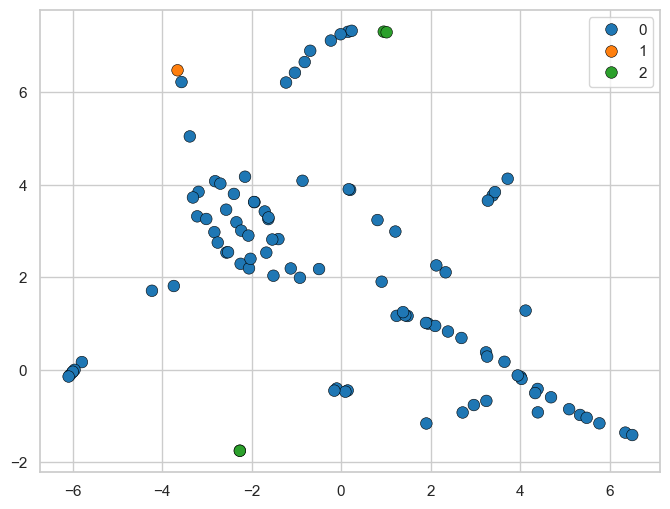

In [78]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Resolve W fallback (keep user's `W` variable if possible)
if 'W' not in globals():
    if 'W_used' in globals():
        W = W_used
    elif 'W_nmf' in globals():
        W = W_nmf
    else:
        raise NameError('W is not defined. Run the BNMF/NMF cell first to obtain W or W_used.')


if 'labels_bnmf' not in globals():
    if 'kmeans_bnmf' in globals():
        labels_bnmf = kmeans_bnmf.labels_
    else:
        warnings.warn('labels_bnmf not found; using zeros as dummy labels')
        labels_bnmf = np.zeros(W.shape[0], dtype=int)

# Ensure W is 2D and has at least 2 columns
if W.ndim != 2:
    W = np.reshape(W, (W.shape[0], -1))
if W.shape[1] < 2:
    from sklearn.decomposition import PCA
    W = PCA(n_components=2).fit_transform(W)


W_umap = None
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    W_umap = reducer.fit_transform(W)
except Exception as _e:
    print('UMAP not available or failed; falling back to t-SNE. Error:', _e)
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    W_umap = tsne.fit_transform(W)

# Safety: make sure W_umap has two columns
if W_umap.ndim == 1:
    W_umap = W_umap.reshape(-1, 1)
if W_umap.shape[1] < 2:
    from sklearn.decomposition import PCA
    W_umap = PCA(n_components=2).fit_transform(W_umap)


if len(labels_bnmf) != W_umap.shape[0]:
    warnings.warn('labels_bnmf length does not match W rows; creating dummy labels')
    labels_bnmf = np.zeros(W_umap.shape[0], dtype=int)

plt.figure(figsize=(8,6))
sns.scatterplot(x=W_umap[:,0], y=W_umap[:,1], hue=labels_bnmf, palette='tab10', s=70, edgecolor='black', linewidth=0.4)
plt.title("")
plt.savefig("figures/bnmf_umap_clusters.eps", dpi=300)
plt.show()

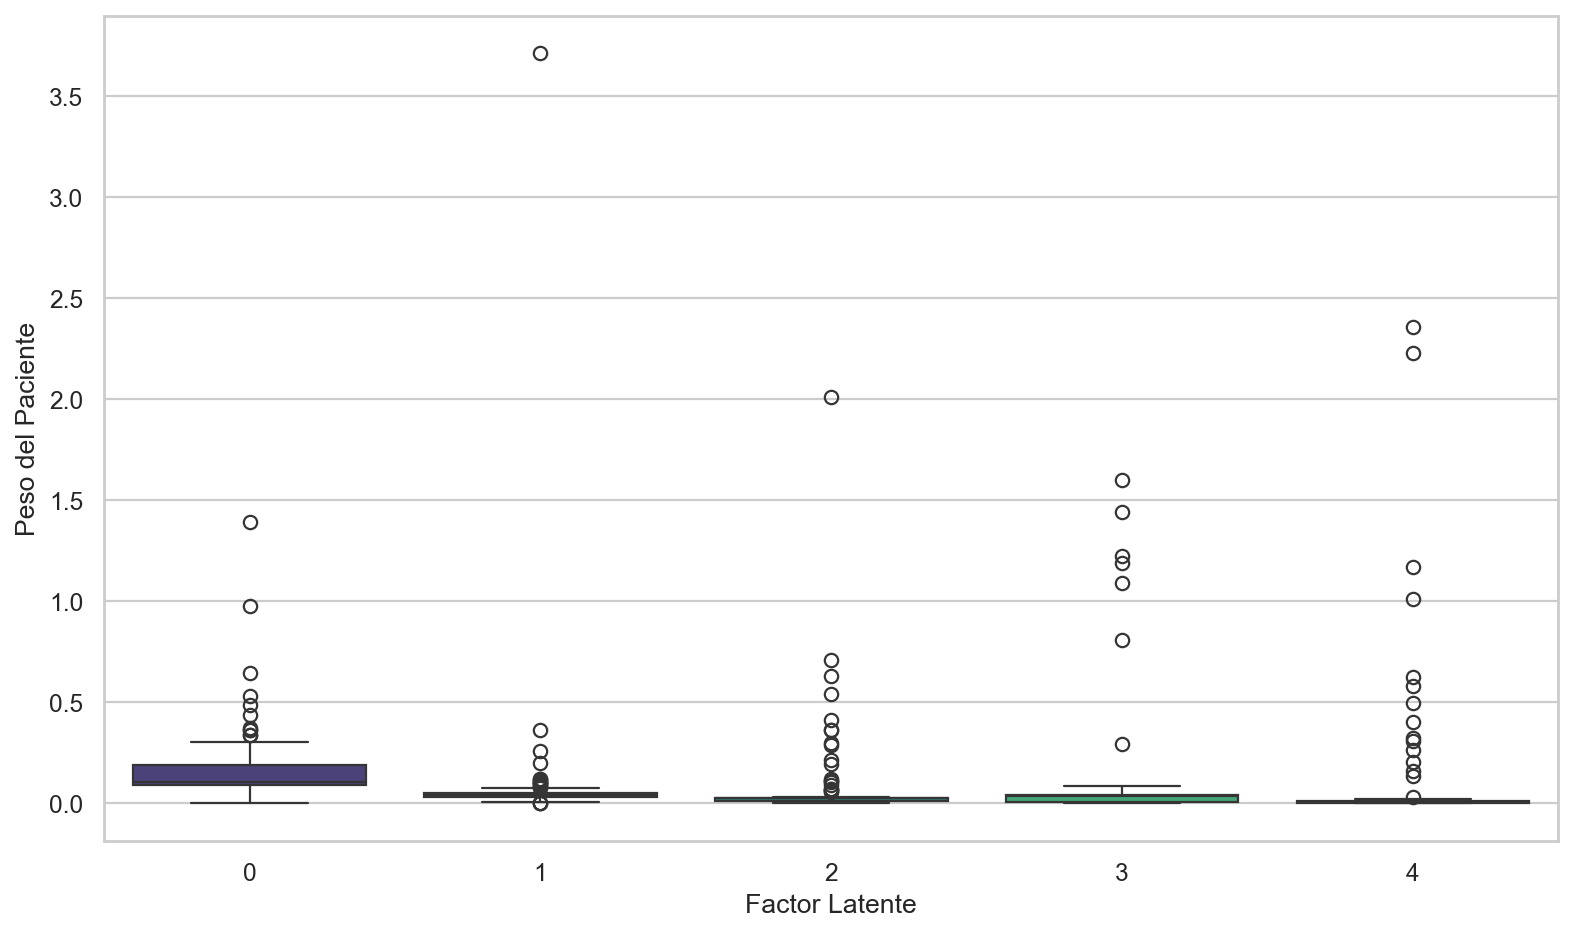

In [79]:
#5A. Distribución de factores latentes BNMF (W)
plt.figure(figsize=(10, 6), dpi=160)
sns.boxplot(data=W, palette="viridis")
plt.title("", fontsize=16, fontweight='bold')
plt.xlabel("Factor Latente", fontsize=12)
plt.ylabel("Peso del Paciente", fontsize=12)
plt.tight_layout()
plt.savefig("figures/bnmf_factor_distributions.png", dpi=300, bbox_inches='tight')
plt.show()


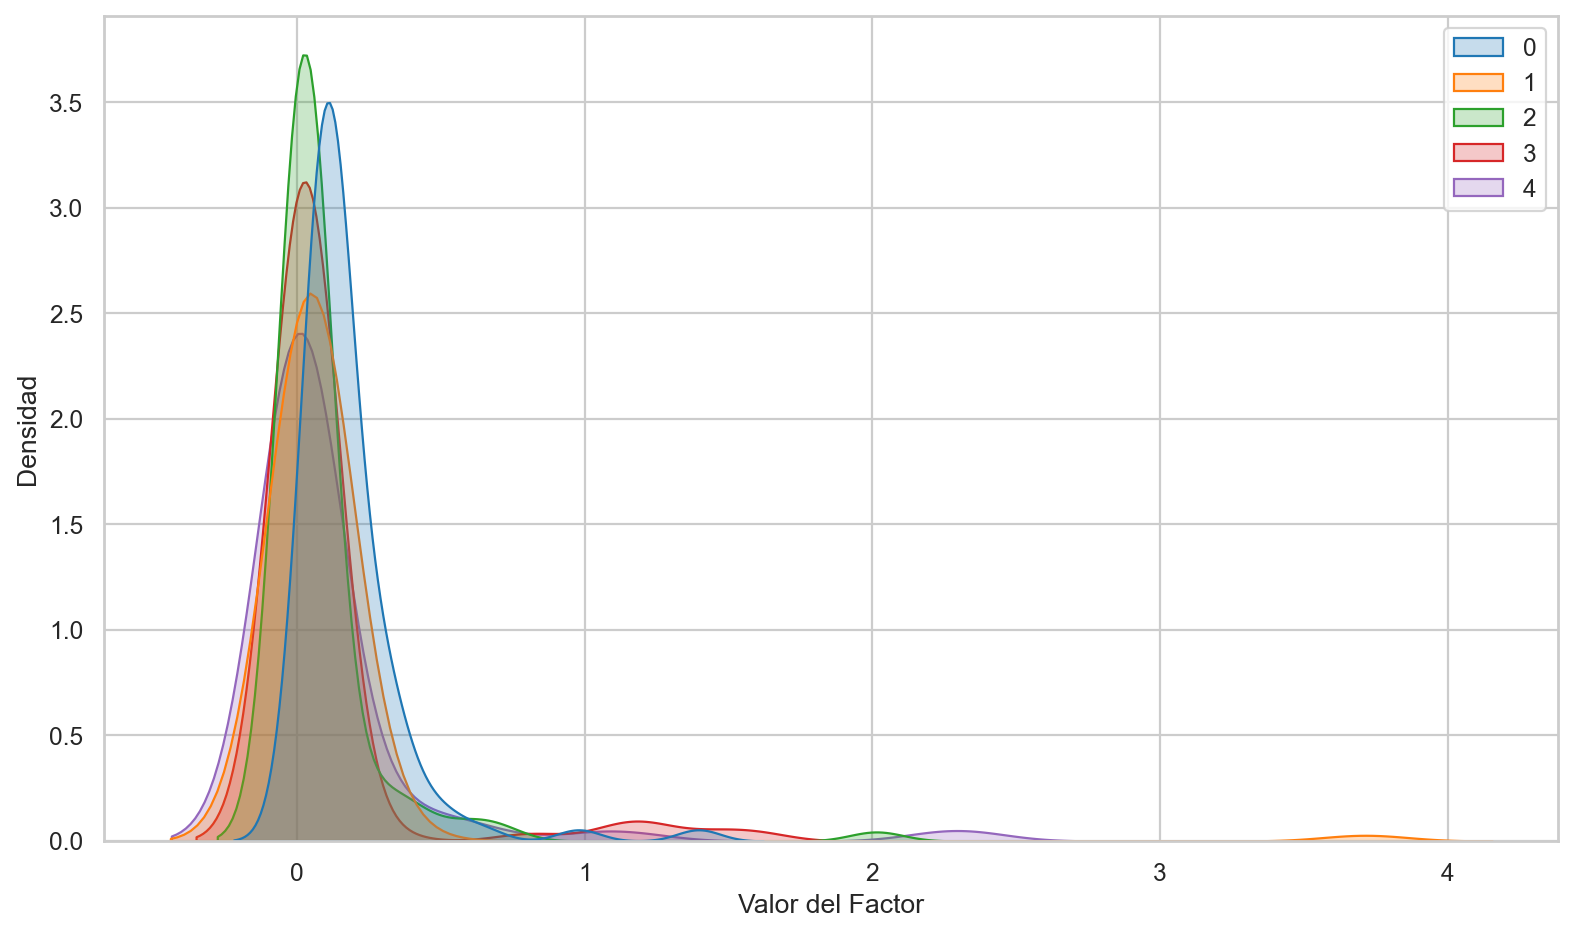

In [80]:
#5B. Densidad de activación de cada factor (W)
plt.figure(figsize=(10, 6), dpi=160)
sns.kdeplot(data=W, fill=True, common_norm=False, palette='tab10')
plt.title("", fontsize=16, fontweight='bold')
plt.xlabel("Valor del Factor", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.tight_layout()
plt.savefig("figures/bnmf_factor_density.png", dpi=300, bbox_inches='tight')
plt.show()


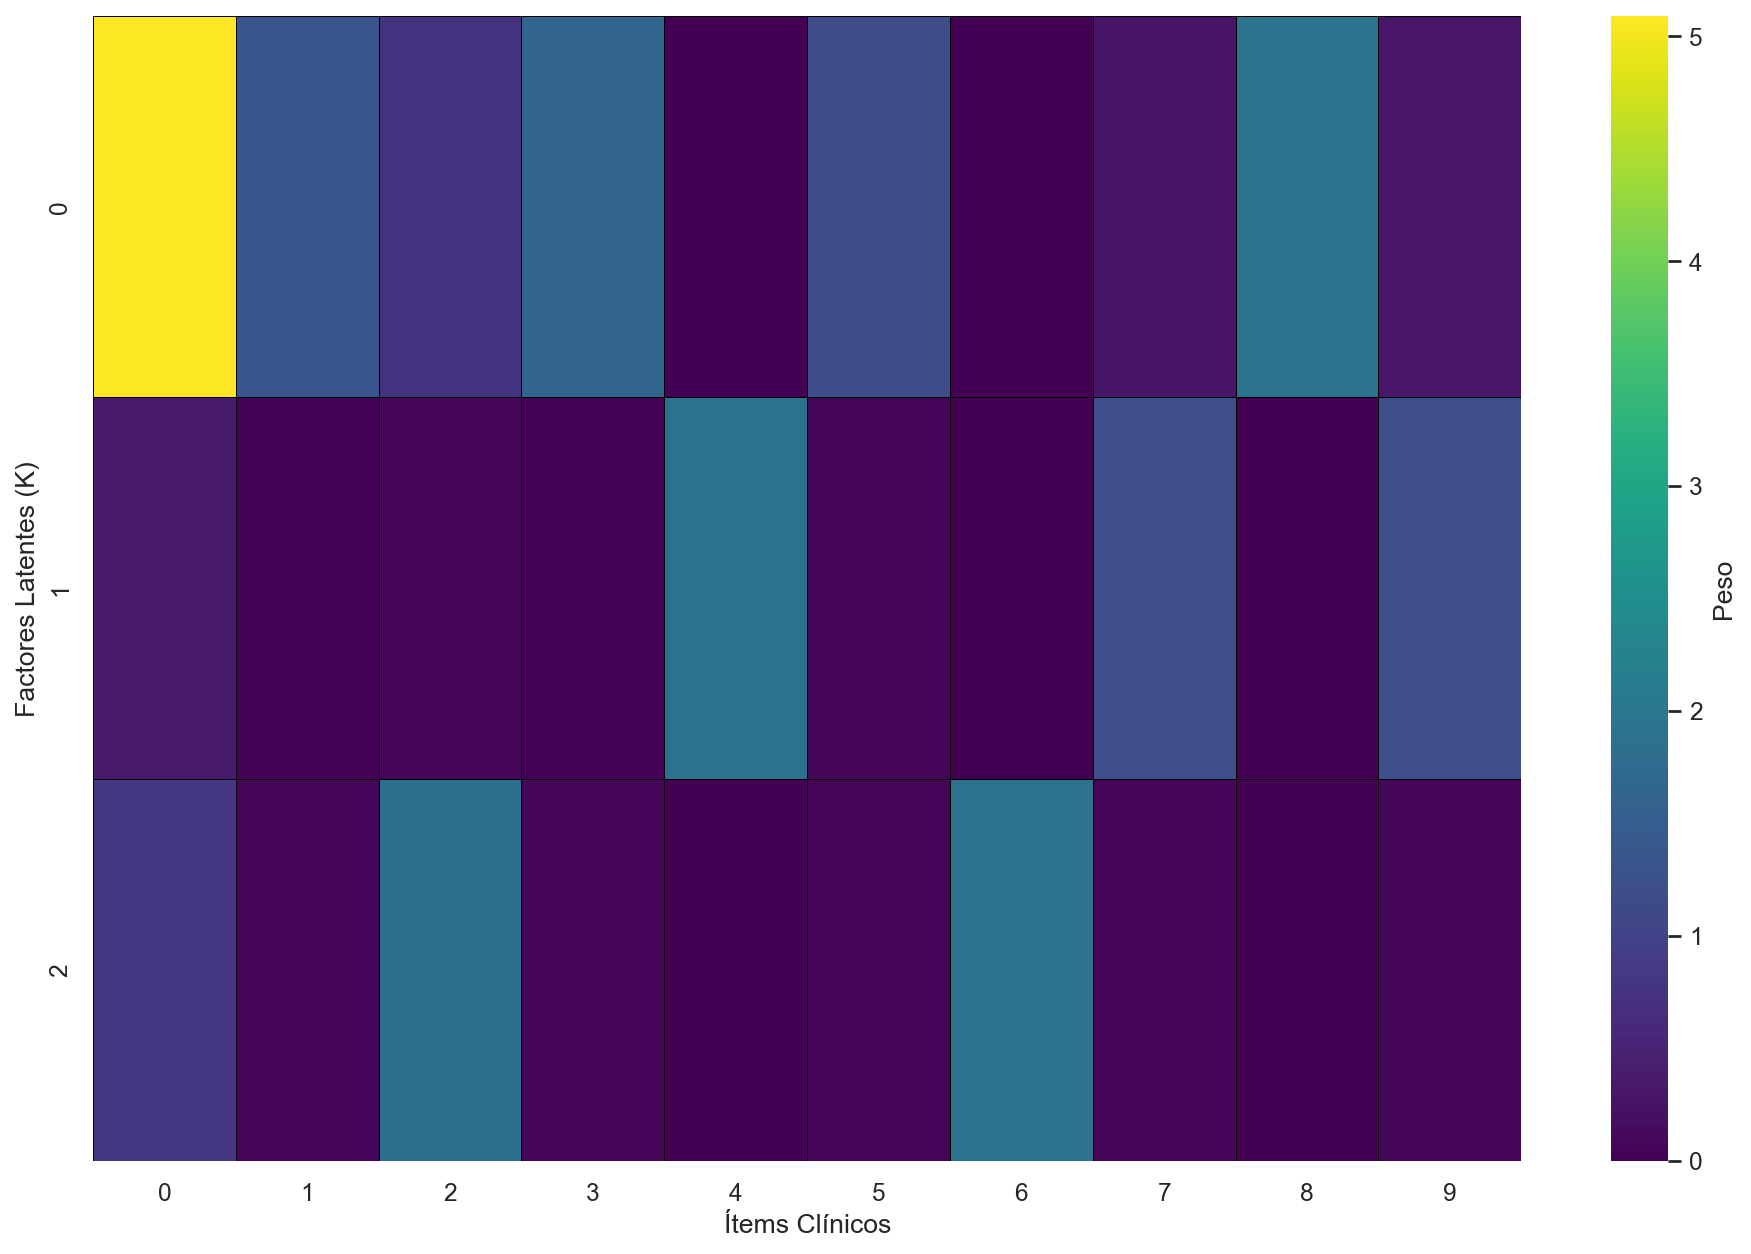

In [81]:
#5C. Mapa de calor del factor H (eventos clínicos ↔ factores)
plt.figure(figsize=(12, 8), dpi=160)
sns.heatmap(H_used, cmap="viridis", cbar_kws={'label': 'Peso'}, 
            linewidths=0.3, linecolor='black')

plt.title("", fontsize=16, fontweight='bold')
plt.xlabel("Ítems Clínicos", fontsize=12)
plt.ylabel("Factores Latentes (K)", fontsize=12)

plt.tight_layout()
plt.savefig("figures/bnmf_H_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


## 6. Comparación de Clustering
En este apartado se comparan los resultados de clustering obtenidos usando los componentes de BNMF y PCA. Se analizan las siguientes métricas y visualizaciones:

- **Inercia (k-Means):** Permite comparar la compacidad de los clusters en cada espacio reducido.
- **Silhouette Score:** Evalúa la separación y cohesión de los clusters.
- **Visualización:** Permite observar la distribución y separación de los grupos.

### Comparación Numérica y Visual

```python
from sklearn.metrics import silhouette_score

# Inercia
inertia_bnmf = kmeans_bnmf.inertia_
inertia_pca = kmeans_pca.inertia_

# Silhouette
sil_bnmf = silhouette_score(W, labels_bnmf)
sil_pca = silhouette_score(X_pca[:, :n_components], labels_pca)

print('--- Comparación de Clustering ---')
print(f'Inercia BNMF: {inertia_bnmf:.2f}')
print(f'Inercia PCA: {inertia_pca:.2f}')
print(f'Silhouette BNMF: {sil_bnmf:.3f}')
print(f'Silhouette PCA: {sil_pca:.3f}')

# Selección automática de la mejor técnica
if sil_bnmf > sil_pca:
    mejor = 'BNMF'
else:
    mejor = 'PCA'
print(f'\nLa mejor técnica de clustering en este desarrollo es: {mejor}')
```

## 7. Conclusiones
- Se selecciona automáticamente la técnica con mejor puntuación de silhouette en este desarrollo.
- Si la inercia y/o el silhouette son mejores en BNMF, indica que la factorización logra una mejor representación de la estructura latente.
- Si PCA obtiene mejores métricas, puede ser más adecuado para este conjunto de datos.
- La interpretación de los componentes BNMF suele ser más sencilla, ya que son aditivos y no negativos.
- La visualización ayuda a identificar si los clusters son bien definidos o se traslapan.

**En este desarrollo, la técnica seleccionada como óptima es la que obtuvo el mejor resultado de silhouette score.**